In [11]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

# # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/genDNA/pymdna/')
import main as mdna 
%load_ext autoreload
%autoreload 2

### DNA spline skeleton

We use a spline defined by `control_points` to define the shape of the DNA. Imagine this to be skeleton of the dsDNA strand. We can use `Shapes` to call parameteric functions of different geometric objects such as lines, circles, helices etc. The `frame_spacing` is the variable that determines the interdistance between the subsequent basepairs, which is set to 0.34 nm equal to the average rise between base pairs. The resulting spline object contains `.frames`, which are of shape (n_bp,frame), with n_bp the number of basepairs and frame of shape (4,3) as the origin, tangent, normal and binormal vectors defining the basis of the frame. Here all the frames follow the tangents along the curvature of the spline pointing towards the subsequent points along the spline, resulting in all frames to be aligned with it's neighbors, e.g.:

 - `control_points = np.array([[0, 0, 0], [1, 1, 1], [2, -1, 2], [3, 0, 1], [4, 2, 1]])*4` 
 - `control_points = np.array([[0, 0, 0], [0.1, 0.05, 0.5], [0.1, 0.05, 0.75],[0.1, 0.05, 4]])`
 - `control_points = np.array([[0, 0, 0], [2.5, 2, 0.0],[7.5, 2, 0.0],[10, 0, 0]])`

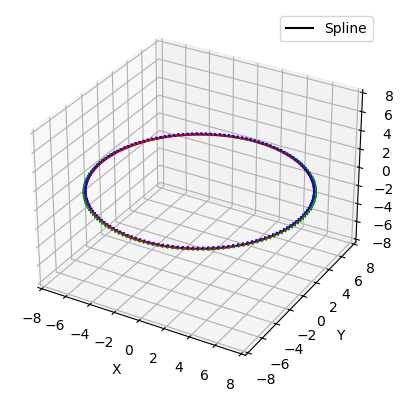

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [10]:
# Get control points from a circle to shape the spline
control_points = mdna.Shapes.circle(radius=8,num_points=100)

# Generate frames from control points
spline = mdna.SplineFrames(
    control_points=control_points, 
    frame_spacing=0.34,
    frame_tolerance=0.05,
    degree=3, 
    num_points = 10000,
    closed=True,
    verbose=False)

# Plot spline with coordinate frames in 3D
spline.plot_frames(equal_bounds=True)

### DNA winding, setting twist and writhe(?)
We still need to add the typical twist of the dubble helical "staircase" in the spline to generate the DNA. In addtion, we would like to have flexibility over sequences which are unwound or more tightly wound (setting linking number shizzle only applicable for circular DNA? or not let's see). To do this we need to twist the frames by 3.6 degrees.  

/Users/thor/surfdrive/Projects/genDNA/workspace/pymdna/utils.py:52: RuntimeWarning: invalid value encountered in divide
  omega_normalized = np.where(omega_norm != 0, omega / omega_norm, omega)


Structure is requested to be circular:
 Excess twist per base to make ends meet: 2.20 degrees


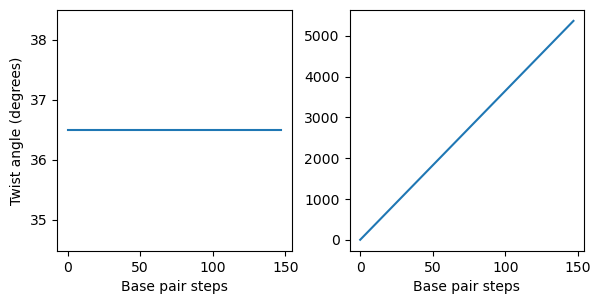

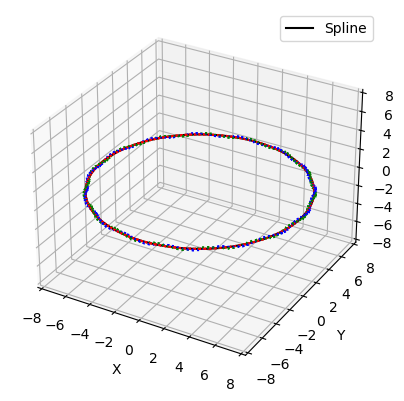

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [3]:
# Twist frames based on bp_per_turn 
spline.twist_frames(bp_per_turn=10.5,plot=True)
spline.plot_frames(equal_bounds=True)

### Map Sequence to Spline

We have now a spline with twisted reference frames for each base pair
Now we need to create a mdtraj object containing the topology and xyz coordinates with `SequenceGenerator`.
To do this we first initialize the topology and xyz with all the cooridnates of the atoms centered in the origin.
Next we compute the mean reference frames of the basepair, which have the same shape as the spline reference frames.
Then transform these coordinates to the spline frames, resulting in a nice ds B-DNA geometry.


In [4]:
# Apply spline to DNA trajectory
dna = mdna.StructureGenerator(spline=spline)
traj = dna.traj # get the mdtraj object based on our spline

TAGAGAACTTTTCTACCGGATACTTTCCTGCAAGGGGATGTTTAATAACCAAGAAGGTATGGTAGCAAAACTCCCCGCATACGAAACTCATGTCCTTGCTTGTCCACTGTGATCCGCAGGAACGGGGTATGCCAATTCACGATTCCGG
Nan value found!
[       nan 0.00264912 0.00264912 0.00264912 0.00264912        nan
 0.00240632 0.00262461        nan        nan        nan 0.00262461
 0.00262461        nan 0.00240632        nan 0.00505993        nan
 0.00264912        nan        nan 0.00240632 0.00262461        nan
        nan 0.00262461        nan 0.00262461 0.00239509 0.00505993
 0.00240632        nan 0.00264912        nan        nan        nan
 0.00264912        nan 0.00239509 0.00239509        nan        nan
        nan        nan        nan        nan        nan 0.00240632
        nan 0.00240632        nan 0.00264912 0.00264912        nan
 0.00264912        nan 0.00239509        nan        nan 0.00239509
        nan 0.00239509        nan 0.00264912 0.00505993 0.00240632
        nan        nan        nan 0.00240632 0.00262461 0.00262461
        nan        nan        

/Users/thor/surfdrive/Projects/genDNA/workspace/pymdna/utils.py:22: RuntimeWarning: invalid value encountered in arccos
  omega = np.arccos(0.5 * (np.trace(R, axis1=-2, axis2=-1) - 1))


In [5]:
view = nv.show_mdtraj(traj)
view.clear_representations()
view.add_representation('ball+stick',selection=traj.top.select('not protein'))
view

NGLWidget()

### Analyze DNA structure with rigid body paramters

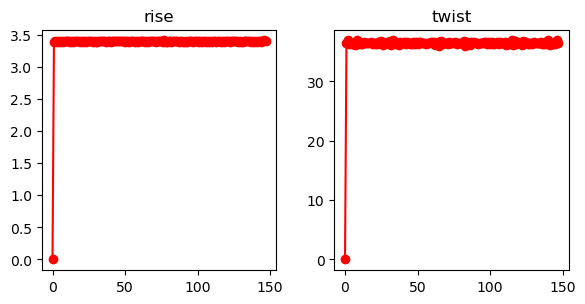

In [7]:
_ = mdna.NucleicFrames(traj)    
params, names = _.get_paramters()
# params.shape, names

# Confidence intervals 
from scipy.stats import t

fig, ax = plt.subplots(1,2,figsize=[6,3])
fig.tight_layout()

M = np.mean(params, axis=0)
S = np.std(params, axis=0)
n = params.shape[0]
ci = t.ppf(0.975, df=n-1) * S / np.sqrt(n)

c = 0
for _, i in enumerate(M.T):
    if _ >= 6:
        c1, c2 = 'red','coral'
    else:
        c1, c2 = 'blue','cornflowerblue'
    if names[_] == 'twist' or names[_] == 'rise':
        ax[c].plot(i[::-1], '-o',color=c1)
        ax[c].set_title(names[_])
        c+=1    
         


### Fix pdb by adding hydrogens and such

In [ ]:
from pdbfixer import PDBFixer
from openmm.app import PDBFile

def do_pdbfix(structure_name,loc='./',fixed_only=False):

    """For circular structures hydrogens at O3' are added, so we need to fix this manually"""

    fixer = PDBFixer(filename=f'{loc}{structure_name}.pdb')
    
    # locate missing atoms/residues
    fixer.findNonstandardResidues()
    fixer.findMissingResidues()
    fixer.findMissingAtoms()

    for residue,atoms in fixer.missingAtoms.items():
        print(residue,len(atoms),'atom(s) :\n', atoms,'\n')

    # Add missing structure
    fixer.replaceNonstandardResidues()
    fixer.addMissingAtoms()
    fixer.addMissingHydrogens(7.0)

    if not fixed_only:
        PDBFile.writeFile(fixer.topology, fixer.positions, open(f'{loc}{structure_name}_fixed.pdb', 'w'))
    else:
        PDBFile.writeFile(fixer.topology, fixer.positions, open(f'{loc}{structure_name}.pdb', 'w'))

name = 'catDNA'
traj.save(f'{name}.pdb')
do_pdbfix(f'{name}',loc='./')

d = md.load(f'./{name}_fixed.pdb')
selection = d.top.select('chainid 0 1')
view = nv.show_mdtraj(d.atom_slice(selection))
view.clear_representations()
view.clear()
view.add_representation('licorice')
view

In [ ]:
d = md.load(f'./{name}_fixed.pdb')
selection = d.top.select('chainid 0')
view = nv.show_mdtraj(d.atom_slice(selection))
view.clear_representations()
view.clear()
view.add_representation('licorice')
view